<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обработка текста</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#CATBOOST-без-предварительной-токенизации" data-toc-modified-id="CATBOOST-без-предварительной-токенизации-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CATBOOST без предварительной токенизации</a></span></li></ul></li><li><span><a href="#Testing-the-best-model" data-toc-modified-id="Testing-the-best-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing the best model</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для интернет-магазина
Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.stem.snowball import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv('datasets/toxic_comments.csv')
df = df.sample(50000, random_state=25).reset_index(drop=True)
display(df.head())
display(df.toxic.value_counts(normalize=True))

,text,toxic
0,i would be astonished if you could produce one...,0
1,"Dearest Doc, I know you're already shocked tha...",0
2,Funny IP Edit\nThat IP you just warned was try...,0
3,I predict that your next fragrant beer-belch w...,0
4,"""\nThomas is absolutely right. Wait until Nint...",0


0    0.89824
1    0.10176
Name: toxic, dtype: float64

Оставим только 50000 текстов, иначе токенизация занимает слишком большое время.

### Обработка текста

Разные варианты обработки сырого текста, лемматизация и стемминг:

In [4]:
lemmatizer = spacy.load('en_core_web_sm')
def lem(text):
    text = text.lower()
    cleared_text = text.replace('\n', ' ')
    cleared_text = " ".join(re.sub(r'[^a-zA-Z ]', '', cleared_text).split())     

    lemm_text = [token.lemma_ for token in lemmatizer(cleared_text)]
    lemm_text = " ".join(lemm_text)
    return lemm_text

In [5]:
stemmer = SnowballStemmer('english')
def stem(text):
    text = text.lower()
    cleared_text = text.replace('\n', ' ')
    cleared_text = " ".join(re.sub(r'[^a-zA-Z ]', '', cleared_text).split())     

    lemm_text = [stemmer.stem(token) for token in cleared_text.split()]
    lemm_text = " ".join(lemm_text)
    return lemm_text

In [6]:
%%time
df['lemm_text'] = df['text'].apply(lem)

Wall time: 8min 59s


Дополнительно можно провести стемминг  каждой леммы.

In [7]:
# %%time
# df['stem_text'] = df['text'].apply(stem)
# df['stem_lemm_text'] = df['lemm_text'].apply(stem)

In [8]:
df.head(3)

,text,toxic,lemm_text
0,i would be astonished if you could produce one...,0,I would be astonish if you could produce one u...
1,"Dearest Doc, I know you're already shocked tha...",0,dearest doc I know you re already shock that d...
2,Funny IP Edit\nThat IP you just warned was try...,0,funny ip edit that ip you just warn be try to ...


### Анализ данных
представим наиболее распространенные слова для каждого класса комментариев

In [9]:
comment_nontoxic = (df[df.toxic == 0]['lemm_text'] + ' ').sum()
comment_toxic = (df[df.toxic == 1]['lemm_text'] + ' ').sum()
comment_all = comment_nontoxic + comment_toxic

In [10]:
stop_words = set(nltk.corpus.stopwords.words('english'))

wordcloud_all = WordCloud(stopwords=stop_words, collocations=False, max_words=100, width=800, max_font_size=50).generate(comment_all)
wordcloud_nontoxic = WordCloud(stopwords=stop_words, collocations=False, max_words=50, width=400, max_font_size=50).generate(comment_nontoxic)
wordcloud_toxic = WordCloud(stopwords=stop_words, collocations=False, max_words=50, width=400, max_font_size=50).generate(comment_toxic)

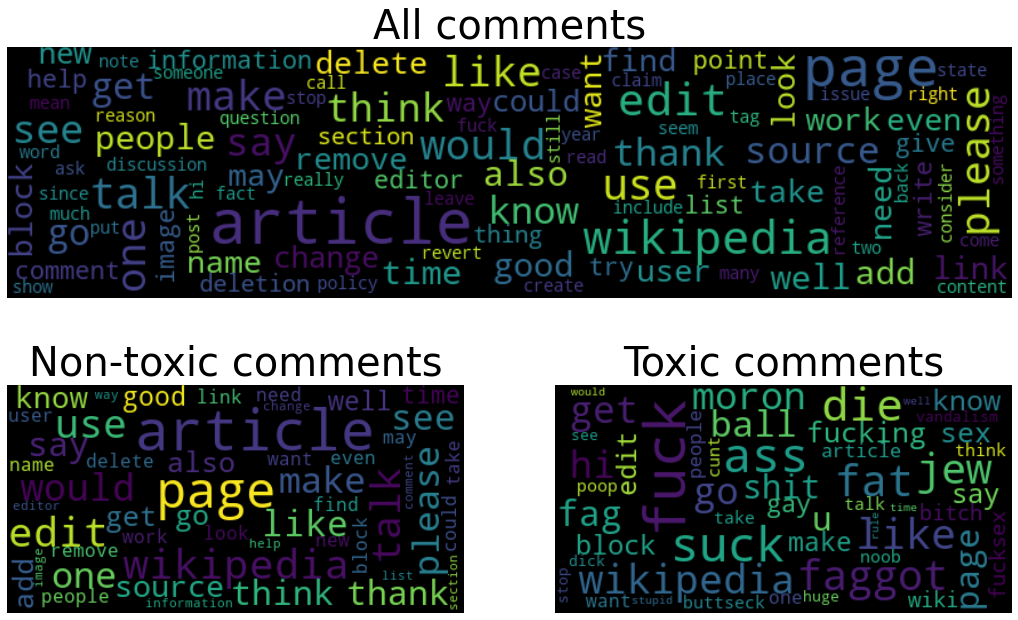

In [11]:
plt.figure(figsize=(18, 11))
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=10)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=1)

ax1.imshow(wordcloud_all, interpolation="bilinear")
ax1.set_title('All comments', fontsize=40)
ax1.axis("off")
ax2.imshow(wordcloud_nontoxic, interpolation="bilinear")
ax2.set_title('Non-toxic comments', fontsize=40)
ax2.axis("off")
ax3.imshow(wordcloud_toxic, interpolation="bilinear")
ax3.set_title('Toxic comments', fontsize=40)
ax3.axis("off")
plt.show()

## Обучение

Проведем токенизацию и дальнейший подбор моделей для лемматизированного текста. Сформируем признаки через TF-IDF.

In [12]:
features_train, features_test, target_train, target_test = train_test_split(df['lemm_text'], df['toxic'], test_size=.2, random_state=25, stratify=df['toxic'])
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=.25, random_state=25, stratify=target_train)

In [13]:
count_vect = TfidfVectorizer(stop_words=stop_words, norm=None)
bow = count_vect.fit_transform(features_train.values)
bow_test = count_vect.transform(features_test.values)

### Logistic Regression

In [14]:
%%time
clf = LogisticRegression(random_state=25, max_iter=10000, solver='lbfgs')
grid = {'C': np.power(10., range(0,10))}
model = GridSearchCV(clf, param_grid=grid, scoring='f1', n_jobs=7, cv=2)
model.fit(bow, target_train)

print(model.best_params_)
print(f'F1-score: {model.best_score_:.3f}')

{'C': 1.0}
F1-score: 0.712
Wall time: 17.7 s


### Random forest

In [16]:
%%time
clf = RandomForestClassifier(random_state=25)
grid = {'n_estimators':range(10,101,30), 'max_depth':range(1,17,5)}
model = GridSearchCV(clf, param_grid=grid, scoring='f1', n_jobs=7, cv=2)
model.fit(bow, target_train)

print(model.best_params_)
print(f'F1-score: {model.best_score_:.3f}')

{'max_depth': 16, 'n_estimators': 10}
F1-score: 0.009
Wall time: 11.3 s


### CATBOOST без предварительной токенизации

In [17]:
%%time
cat = CatBoostClassifier(random_state=25, verbose=0)
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [1, 3, 5]}
model = GridSearchCV(cat, param_grid=grid, scoring='f1', n_jobs=7, cv=2)
model.fit(pd.DataFrame(features_train), 
          target_train,  
          text_features=['lemm_text'], 
          eval_set=(pd.DataFrame(features_valid), target_valid))

print(model.best_params_)
print(f'Logloss-score: {model.best_score_:.3f}')

{'depth': 5, 'learning_rate': 0.05}
Logloss-score: 0.736
Wall time: 5min 43s


**Вывод**: лучшее качество на тренировочных данных показывает CatBoost (F1 = 0.736). Будем использовать его с параметрами `{'depth': 5, 'learning_rate': 0.05}`
## Testing the best model

In [18]:
cat = CatBoostClassifier(random_state=25, verbose=0, **{'depth': 5, 'learning_rate': 0.05})
cat.fit(pd.DataFrame(features_train),  
        target_train, 
        text_features=['lemm_text'], 
        eval_set=(pd.DataFrame(features_valid), target_valid))

pred = cat.predict(pd.DataFrame(features_test))
print("F1-score:", round(f1_score(target_test, pred), 3))

F1-score: 0.77


## Выводы
Для анализа токсичности твитов выбрали отобрали 10 тыс. твитов из предложенного датасета. Далее с помощью модели BERT токенизировали тексты (использовали предобученную модель 'distilbert-base-uncased' из библиотеки pytorch_pretrained_bert).
На олученнном векторном представлении текстов тренировали модели и подбирали гиперпараметры для моделей логистической регрессии, случайного леса и lightGBM. Лучшее значение на тренировочных данных показала модель (значение метрики F1 0.74). На тестовых данных данная модель показывает значение метрики 0.77. 